# **Course Recommender System (Clustering based)**


The clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group.
For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.


A user profile vector may look like a row vector in the following matrix, for example, we can see the Database column for user2 has a value 1 which means user2 is very interesting in courses related to the databases. With the user profile vectors generated, we can also easily compute the similarity among users based on their shared interests.

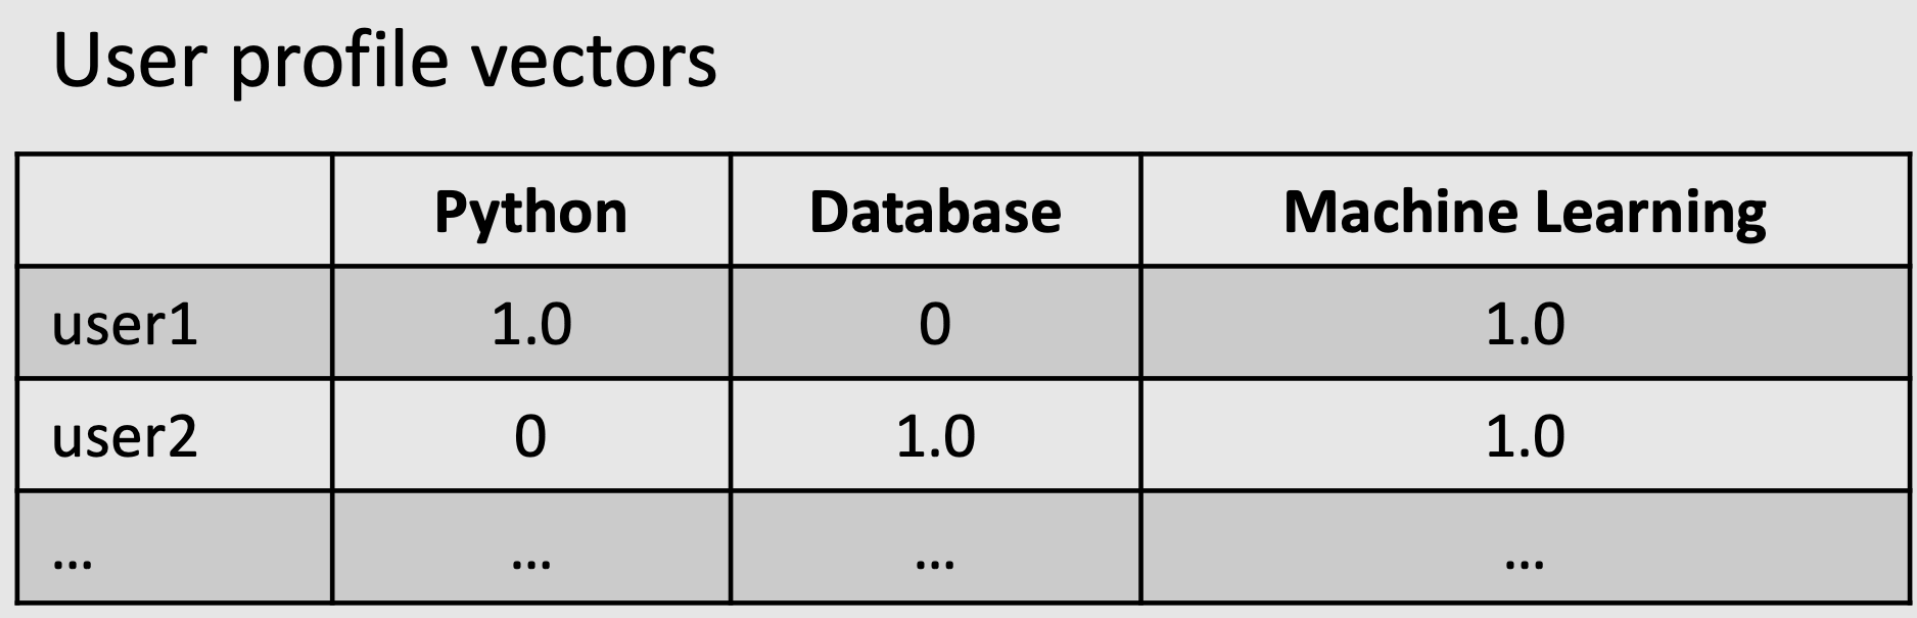

Furthermore, we could perform clustering algorithms such as K-means or DBSCAN to group users with similar learning interests. For example, in the below user clusters, we have user clusters whom have learned courses related to machine learning, cloud computing, databases, and web development, etc.


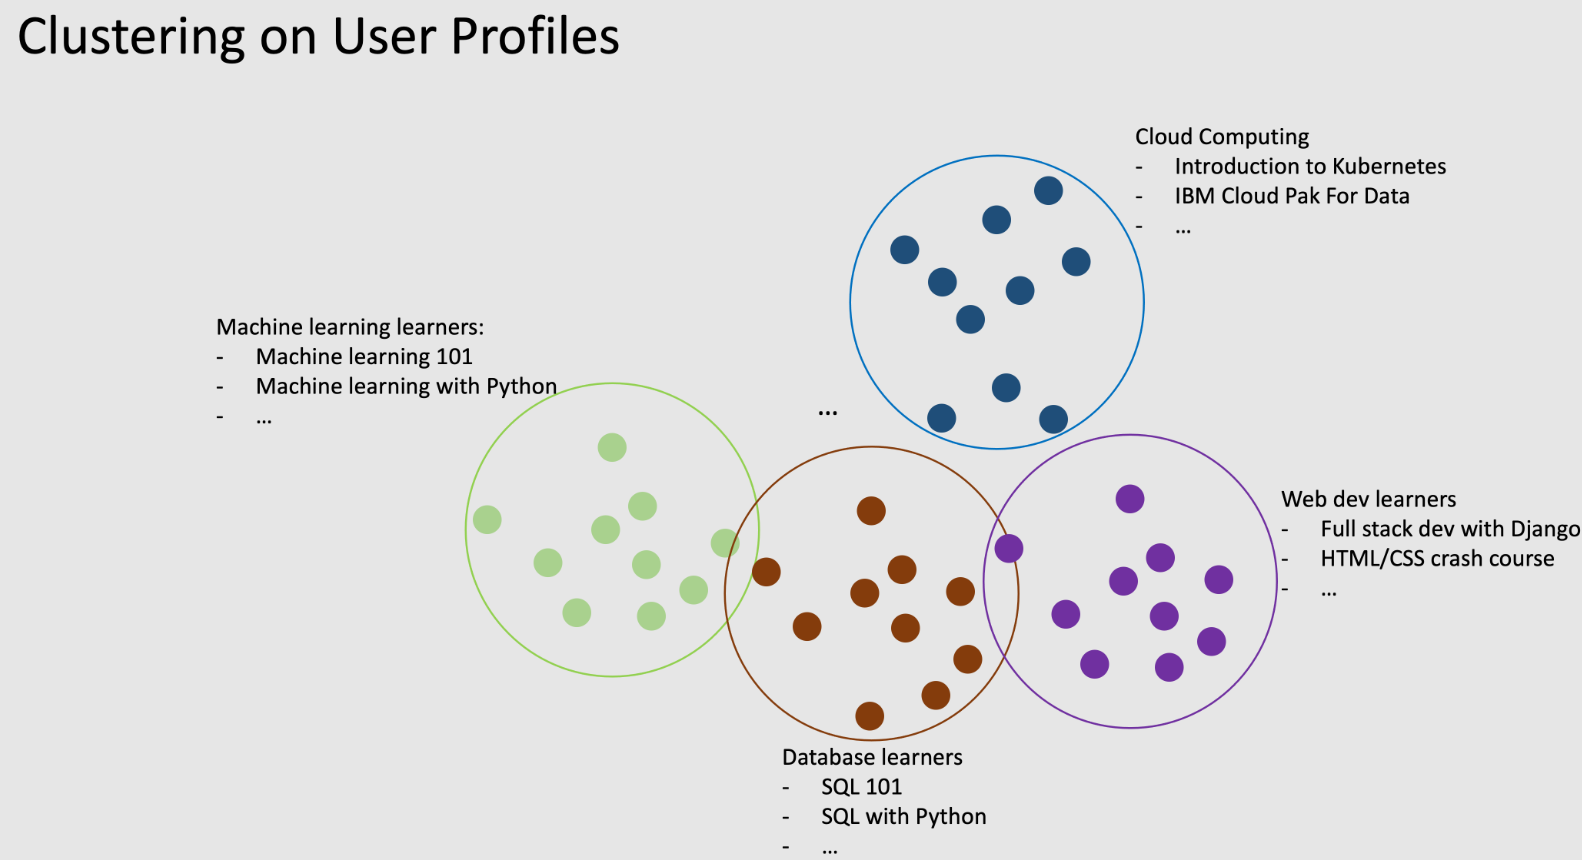

For each user group, we can come up with a list of popular courses. For example, for the machine learning user cluster/learning group, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning.

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.


After completing this, we will be able to:


* Perform k-means clustering on the original user profile feature vectors
* Apply PCA (Principle Component Analysis ) on user profile feature vectors to reduce dimensions
* Perform k-means clustering on the PCA transformed main components
* Generate course recommendations based on other group members' enrollment history


----


## Prepare and setup lab environment


In [24]:
#Importing useful libraries

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [25]:
# Setting a default random state
rs = 123

### Load the user profile dataset


Let's first load the original user profile feature vectors:


In [26]:
user_profile_df = pd.read_csv('user_profile.csv')
user_profile_df.head()


,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [27]:
user_profile_df.shape

(33901, 15)

we list the feature names, they are the user interested topics (course genres):


In [28]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

As we can see from the user profile dataset, we have about 33K unique users with interests in areas like ``Database``, ``Python``, ``CloudComputing``, etc. Then, let's check the  summary statistics for each feature.


In [29]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefore we standardize the data using StandardScaler.


In [30]:
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
print("mean {} and standard deviation{} ".format(user_profile_df[feature_names].mean(), user_profile_df[feature_names].std()))

mean Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


In [31]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,1.064064e+06,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,4.972578e+05,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2.000000e+00,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,6.813480e+05,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,1.043907e+06,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,1.451159e+06,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,2.103039e+06,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are:


In [32]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


we now save the user ids for later recommendation tasks:

In [33]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


### Performing K-means clustering algorithm on the user profile feature vectors


With the user profile dataset ready, we use `KMeans` class provided by scikit-learn library to perform clustering on the user profile feature vectors.


For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`:


In [34]:
n_clusters = range(1, 41)
sum_of_squared_distances = []
for k in n_clusters:
    model = KMeans(n_clusters=k, random_state=rs).fit(features)
    sum_of_squared_distances.append(model.inertia_)

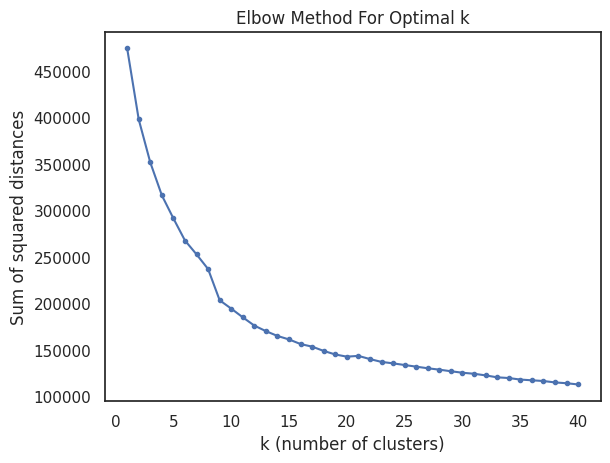

In [35]:
plt.plot(n_clusters, sum_of_squared_distances, '.-',)
plt.xlabel('k (number of clusters)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the elbow plot, we can visualy identify the point where the metric starting to be flatten, which indicates the optimized number of clusters. Here, that value of k is **20**


Applying KMeans() on the features with optimized n_cluster = 20

In [36]:
model = KMeans(n_clusters=20, random_state=rs).fit(features)

In [37]:
labels = model.labels_

The cluster labels generated is a list of integers indicating cluster indices. We use following method to combine the cluster labels and user ids to a dataframe, so that you know which cluster a user belongs:


In [38]:
def combine_cluster_labels(user_ids, labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    # Rename columns to 'user' and 'cluster'
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [39]:
combine_cluster_labels(user_ids, labels)

,user,cluster
0,2,7
1,4,11
2,5,7
3,7,6
4,8,15
...,...,...
33896,2102054,5
33897,2102356,6
33898,2102680,1
33899,2102983,6


Now, each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.


### Applying PCA on user profile feature vectors to reduce dimensions


In [40]:
# Extracting features from the user_profile_df DataFrame, excluding the 'user' column
features = user_profile_df.loc[:, user_profile_df.columns != 'user']

# Extracting user IDs from the user_profile_df DataFrame
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']

# Creating a list of feature names by excluding the 'user' column name
feature_names = list(user_profile_df.columns[1:])

In [41]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:


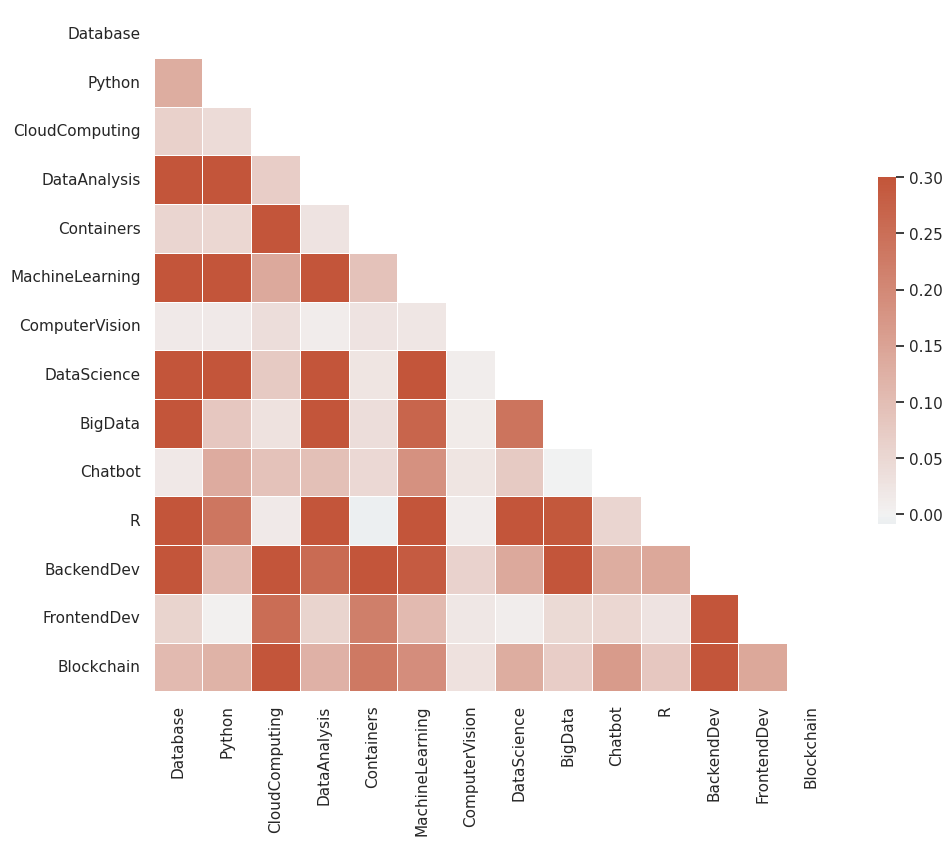

In [42]:
sns.set_theme(style="white")
corr = features.cov()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix).

If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.


Now let's apply the `PCA()` provided by  `scikit-learn` to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.


When we call the  `PCA()` class, there is also an import argument called `n_components` which indicates how many components you want to keep in the PCA result. One way to find an optimized `n_components` is to do a grid search on a list of argument candidates (such as `range(1, 15)`) and calculate the ratio of the accumulated variance for each candidate.

If the accumulated variances ratio of a candidate `n_components` is larger than a threshold, e.g., 90%, then we can say the transformed `n_components` could explain about 90% of variances of the original data variance and can be considered as an optimized components size.


_Finding the optimized `n_components` for PCA_


In [43]:
from sklearn.decomposition import PCA
optimal_n_components = None
n_components_list = []
accumulated_variance_ratios = []
for n_components in range(1, 15):
    pca = PCA(n_components=n_components)
    pca.fit_transform(features)
    accumulated_variance_ratio = sum(pca.explained_variance_ratio_)
    n_components_list.append(n_components)
    accumulated_variance_ratios.append(accumulated_variance_ratio)
    if(accumulated_variance_ratio >=0.9 and optimal_n_components == None):
      optimal_n_components = n_components

print(f"The smallest number of components that explain at least 90% of the variance is: {optimal_n_components}")


The smallest number of components that explain at least 90% of the variance is: 9


_Visualizing this process_

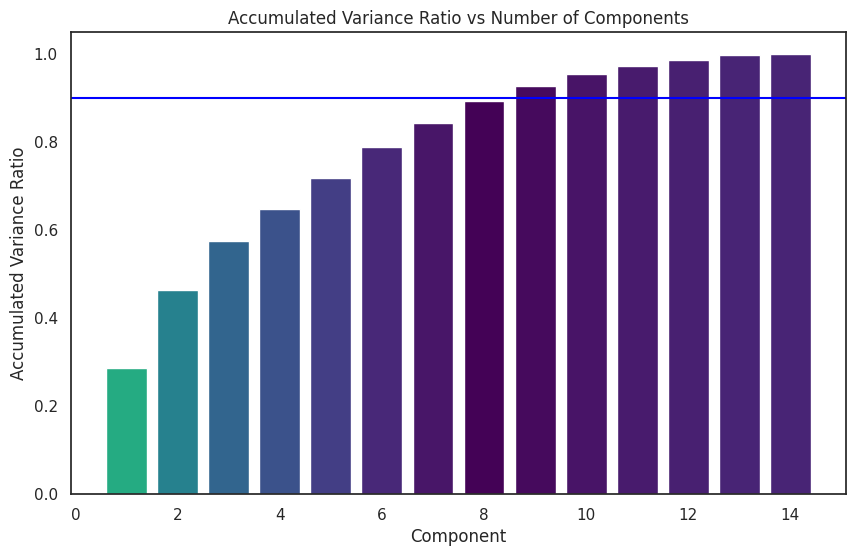

In [44]:
# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(n_components_list, accumulated_variance_ratios, color=plt.cm.viridis([abs(num - 0.9) for num in accumulated_variance_ratios]))

# Add a horizontal line at 0.9 for the 90% threshold
plt.axhline(y=0.9, color='blue', linestyle='-')

# Label the axes and the graph
plt.xlabel('Component')
plt.ylabel('Accumulated Variance Ratio')
plt.title('Accumulated Variance Ratio vs Number of Components')

# Show the plot
plt.show()

We have found the optimized `n_component` argument value, we now apply PCA on the user profile feature vectors and reduce the  14 features into  9 features.


Performing PCA to transform original user profile features_


In [45]:
pca = PCA(n_components=optimal_n_components)
components = pca.fit_transform(features)
columns = [f'PC{i+1}' for i in range(optimal_n_components)]
transformed_df = pd.DataFrame(data=components, columns=columns)
final_df = pd.merge(user_ids, transformed_df, left_index=True, right_index=True)
final_df

,user,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,2102356,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,2102680,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,2102983,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


### Performing k-means clustering on the PCA transformed feature vectors


Now, we have the PCA  components of the original profile vectors. We can perform k-means on them again:


Performing K-means on the PCA transformed features_


In [46]:
n_clusters = range(1, 41)
sum_of_squared_distances = []
for k in n_clusters:
    model = KMeans(n_clusters=k, random_state=rs).fit(transformed_df)
    sum_of_squared_distances.append(model.inertia_)

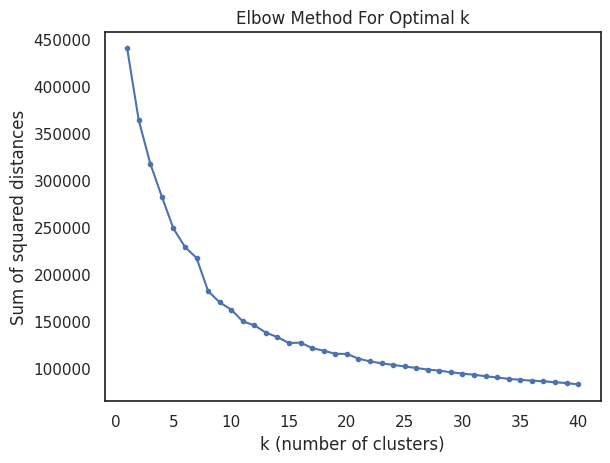

In [47]:
plt.plot(n_clusters, sum_of_squared_distances, '.-',)
plt.xlabel('k (number of clusters)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Again, the optimal value of `n_clusters` is 20

In [48]:
model = KMeans(n_clusters=20, random_state=rs).fit(transformed_df)

In [49]:
labels = model.labels_
cluster_df  = combine_cluster_labels(user_ids, labels)

Now, we can see the cluster for each of the user.

In [50]:
cluster_df

,user,cluster
0,2,12
1,4,14
2,5,12
3,7,19
4,8,9
...,...,...
33896,2102054,13
33897,2102356,19
33898,2102680,1
33899,2102983,19


### Generating course recommendations based on the popular courses in the same cluster


Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:


In [51]:
test_users = pd.read_csv('rs_content_test.csv')
test_users.head()

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0


In [52]:
# Selecting only the 'user' and 'item' columns using indexing
test_users_df = test_users[['user', 'item']]
test_users_df.head()

,user,item
0,1502801,RP0105EN
1,1609720,CNSC02EN
2,1347188,CO0301EN
3,755067,ML0103EN
4,538595,BD0115EN


The test users dataset has only two columns, the user id and the enrolled course id.


For each user, let's find its cluster label using the k-means results we have performed in previous steps.


In [53]:
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled

,user,item,cluster
0,1502801,RP0105EN,0
1,1502801,BD0131EN,0
2,1502801,BD0212EN,0
3,1502801,BD0115EN,0
4,1502801,BD0211EN,0
...,...,...,...
9397,630511,BD0121EN,17
9398,630511,SC0101EN,17
9399,630511,BD0111EN,17
9400,630511,BD0115EN,17


From the above dataframe, we know each user's enrolled courses and its cluster index.


If we use a `groupby`  and `sum` aggregation, we get the enrollments count for each course in each group, like the following code snippet:


In [54]:
# Extracting the 'item' and 'cluster' columns from the test_users_labelled DataFrame
courses_cluster = test_users_labelled[['item', 'cluster']]
# Adding a new column 'count' with a value of 1 for each row in the courses_cluster DataFrame
courses_cluster['count'] = [1] * len(courses_cluster)
# Grouping the DataFrame by 'cluster' and 'item', aggregating the 'count' column with the sum function,
# and resetting the index to make the result more readable
courses_cluster_grouped = courses_cluster.groupby(['cluster','item']).agg(enrollments=('count','sum')).reset_index()
courses_cluster_grouped

,cluster,item,enrollments
0,0,AI0111EN,1
1,0,BC0101EN,6
2,0,BD0101EN,27
3,0,BD0111EN,35
4,0,BD0115EN,30
...,...,...,...
1190,19,TA0105EN,5
1191,19,TA0106EN,8
1192,19,TMP0105EN,7
1193,19,WA0101EN,21


_For each test user, we try to recommend any unseen courses based on the popular courses in his/her cluster. We use an enrollment count threshold (larger than 10) to determine if it is a popular course in the cluster_


In [55]:
test_users_labelled['Recommendations'] = None
test_users_labelled['Number of Recommendations'] = None

for index, user in test_users_labelled.iterrows():
    cluster_id = user['cluster']
    # We create a user_subset of test_users_labelled where test_users_labelled['user'] == cluster_id
    user_subset = test_users_labelled[test_users_labelled['cluster'] == cluster_id]
    current_enrolled_courses = set(user_subset[user_subset['user'] == user['user']]['item'])
    all_courses = set(user_subset['item'])
    unseen_courses = all_courses.difference(current_enrolled_courses)
    # We use `courses_cluster` data set to find popularity of new/unseen courses and make unseen and popular courses as # recommendation results for the user
    recommendation_results = courses_cluster_grouped.loc[(courses_cluster_grouped['item'].isin(unseen_courses)) & (courses_cluster_grouped['enrollments'] > 10), 'item'].tolist()
    test_users_labelled.at[index, 'Recommendations'] = recommendation_results
    test_users_labelled.at[index, 'Number of Recommendations'] = len(recommendation_results)


In [56]:
test_users_labelled

,user,item,cluster,Recommendations,Number of Recommendations
0,1502801,RP0105EN,0,"[BD0121EN, BD0123EN, BD0143EN, BD0145EN, DS010...",164
1,1502801,BD0131EN,0,"[BD0121EN, BD0123EN, BD0143EN, BD0145EN, DS010...",164
2,1502801,BD0212EN,0,"[BD0121EN, BD0123EN, BD0143EN, BD0145EN, DS010...",164
3,1502801,BD0115EN,0,"[BD0121EN, BD0123EN, BD0143EN, BD0145EN, DS010...",164
4,1502801,BD0211EN,0,"[BD0121EN, BD0123EN, BD0143EN, BD0145EN, DS010...",164
...,...,...,...,...,...
9397,630511,BD0121EN,17,"[BD0101EN, BD0123EN, BD0131EN, BD0141EN, BD014...",198
9398,630511,SC0101EN,17,"[BD0101EN, BD0123EN, BD0131EN, BD0141EN, BD014...",198
9399,630511,BD0111EN,17,"[BD0101EN, BD0123EN, BD0131EN, BD0141EN, BD014...",198
9400,630511,BD0115EN,17,"[BD0101EN, BD0123EN, BD0131EN, BD0141EN, BD014...",198


So, here we have made recommendations for each user in our test_dataset. Let's find average number of recommendations for a user.

In [66]:
print(f'Average number of recommendations: {test_users_labelled["Number of Recommendations"].mean()}')

Average number of recommendations: 149.47755796639012


## Thank you for reading!